In [1]:
#!pip install celery

In [2]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from copy import deepcopy

from celery import group
from kmeans_workers import kmeans_tasks, dist


In [3]:
n_samples=1600
n_clusters=3
n_features =2
n_workers = 4

In [4]:
class PointsLabels():
    def __init__(self,X,y):
        #print(X)
        self.points = np.array(X)
        self.label = y
        #print('X:',X)
        #print('label:',y)
        

In [5]:
# Creating a n_features=2 Dim dataset with centers=3 clusters
Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters)

In [6]:
mydata= [PointsLabels(x,np.random.randint(n_clusters)) for x in Xs]

print(len(mydata))
print(mydata[15].points,mydata[15].label)

1600
[-6.45457115  9.76162498] 0


In [7]:
# Split the sequence in a number of chunks and process those independently.

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])


In [8]:
len(Xsubseqs[0])

400

In [9]:
np.matrix(np.diag(np.max(Xs,0)))

matrix([[ 6.07291773,  0.        ],
        [ 0.        , 12.78530029]])

In [10]:
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))
print("Initial Centroids")
print(C)


Initial Centroids
[[3.52814921 6.90152439]
 [0.58211125 5.99423315]
 [2.74838196 7.60438224]]


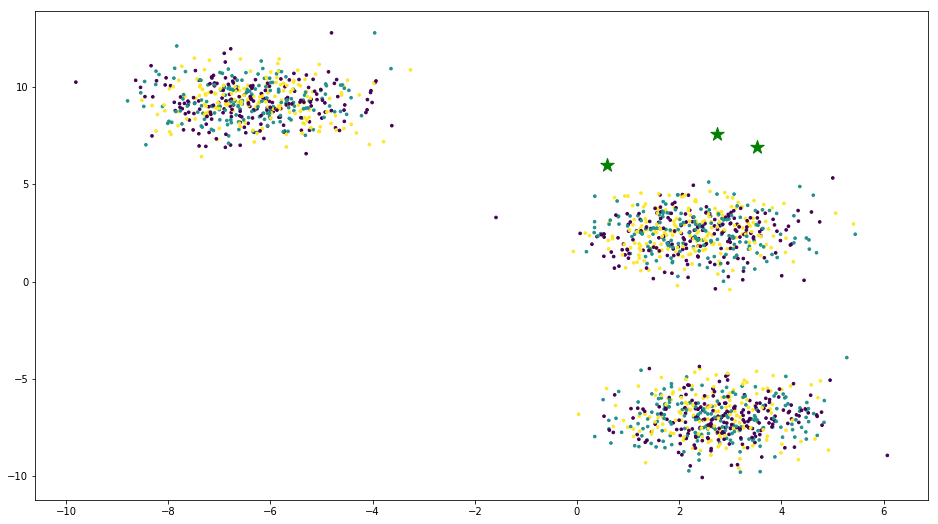

In [11]:
plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()

# Plotting along with the Centroids
#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata])
plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c=[actdata.label for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [12]:
len([actdata.label for actdata in mydata])

1600

In [13]:
# To store the value of centroids when it updates
C_old = np.zeros(C.shape)
# Error func. - Distance between new centroids and old centroids
error = dist(C, C_old, None)
print(error)

12.71726357837683


In [14]:
print(C)
print(C.shape)

[[3.52814921 6.90152439]
 [0.58211125 5.99423315]
 [2.74838196 7.60438224]]
(3, 2)


In [15]:
partials_Estep=[kmeans_tasks(task='estep', C=C, X=seq) for seq in Xsubseqs]

*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***


In [16]:
# the updated labels are here:
len(partials_Estep[0])

400

In [17]:
len(partials_Estep)

4

In [18]:
partials_Mstep=[kmeans_tasks(task='mstep', X=seq, n_clusters=n_clusters, n_features=n_features) for seq in partials_Estep]

*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
partials_Mstep

[[array([3.7640029 , 2.37545051]),
  array([-0.92863492,  1.69809246]),
  array([0., 0.])],
 [array([3.5910943 , 3.06358692]),
  array([-0.43584292,  1.28701642]),
  array([0., 0.])],
 [array([3.79984511, 3.13137362]),
  array([-0.92874969,  1.68841024]),
  array([0., 0.])],
 [array([3.83390119, 2.82234176]),
  array([-0.53997455,  1.3056213 ]),
  array([0., 0.])]]

In [20]:
C=np.sum(partials_Mstep,0)/n_workers
print(C)

[[ 3.74721088  2.8481882 ]
 [-0.70830052  1.4947851 ]
 [ 0.          0.        ]]


In [21]:
# Storing the old centroid values
C_old = deepcopy(C)
 

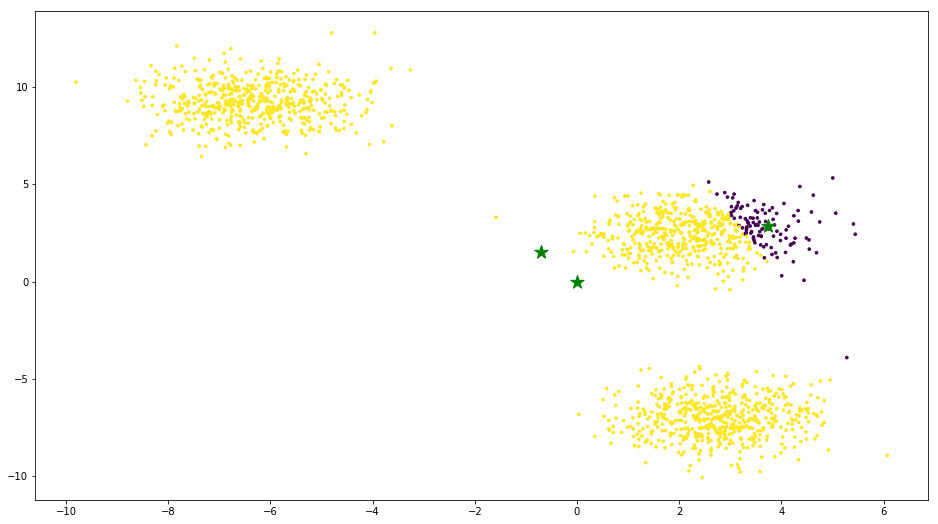

In [22]:
# Plotting along with the Centroids

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c=[actdata.label for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


### Everything together

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


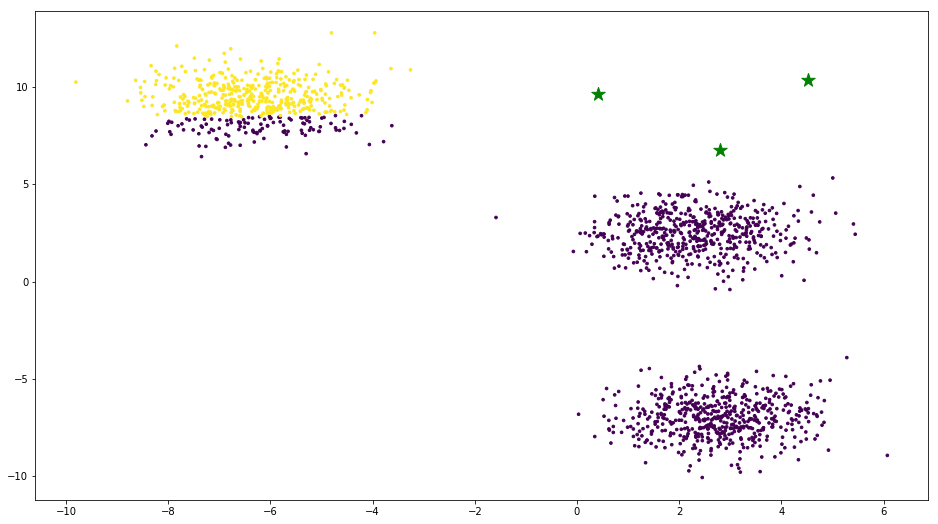

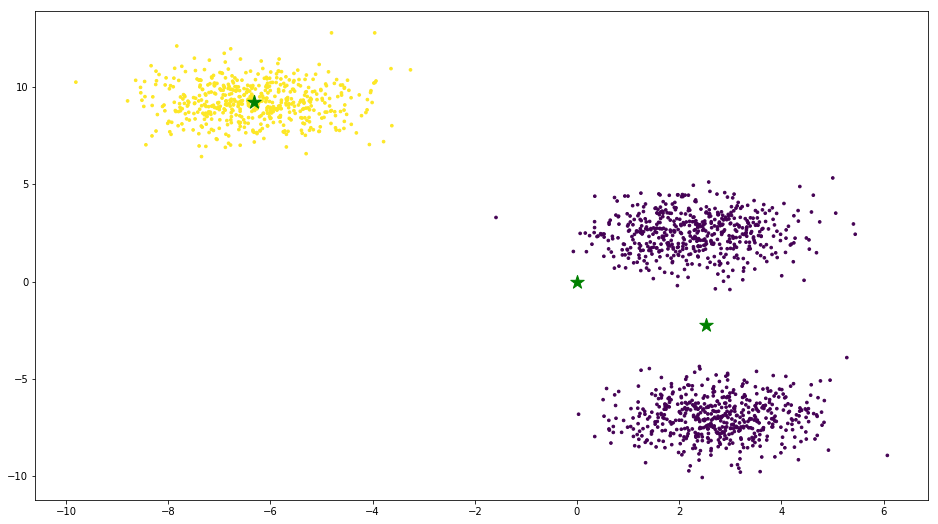

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


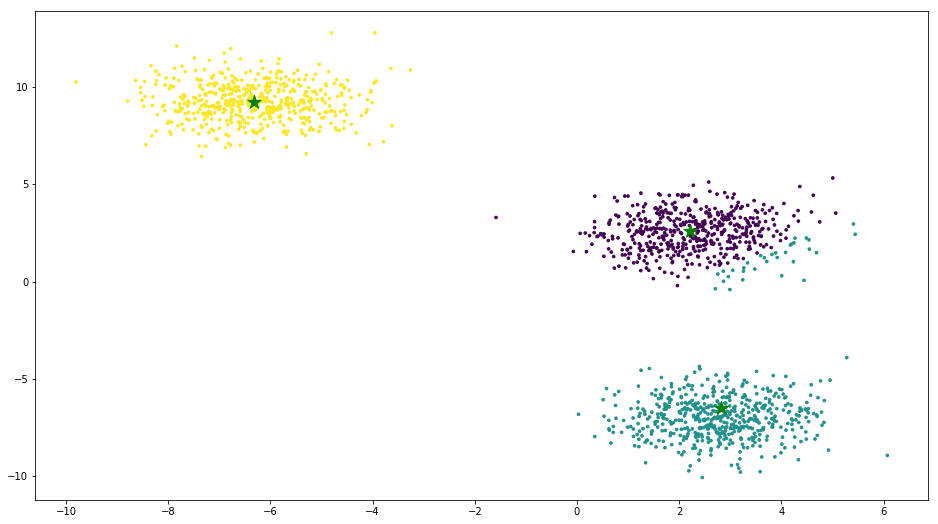

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


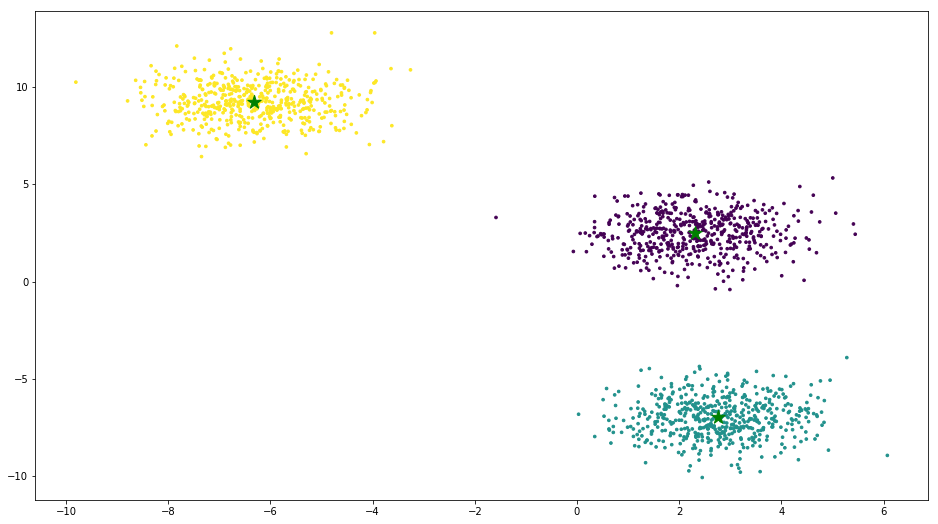

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


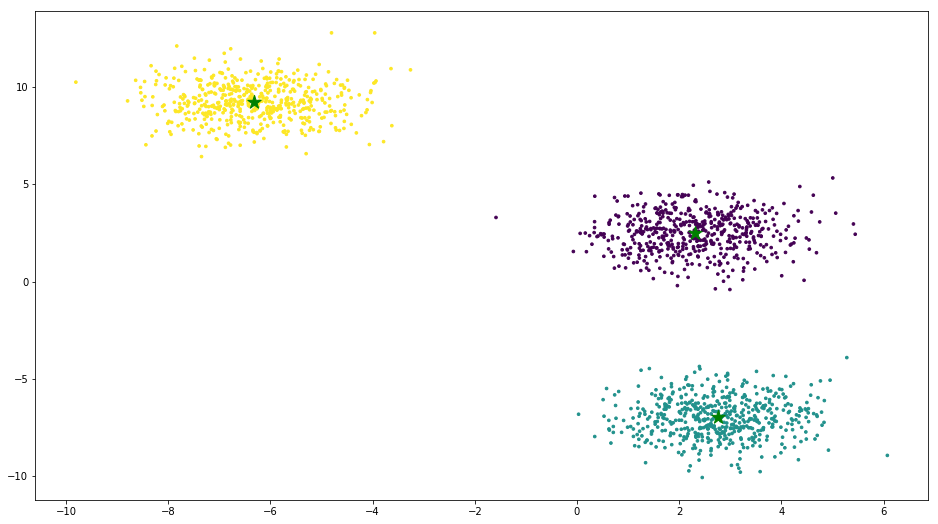

(3, 2)
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the E-Step ***
 *** Labels updated. E-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
*** we are in the M-Step ***
 *** Cluster centers updated. M-step done ***
0.0
400
400
400
400


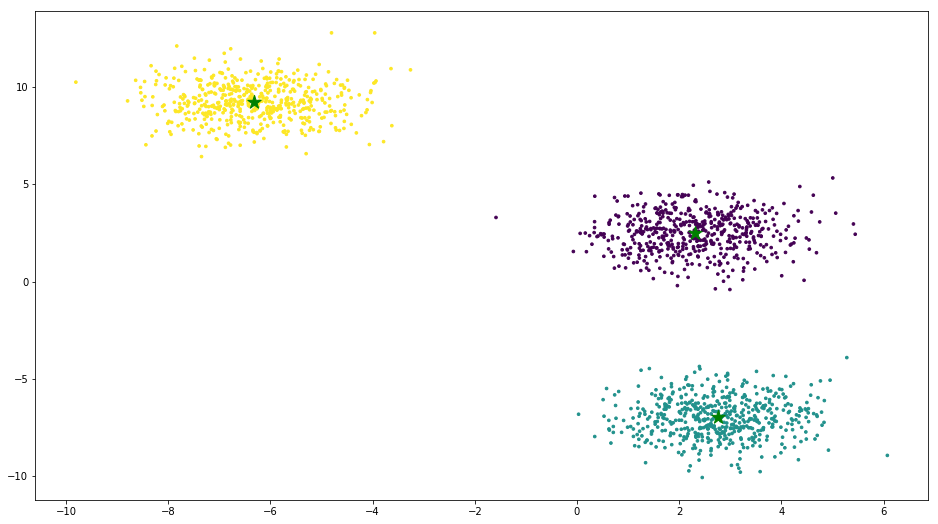

In [24]:
# Split the sequence in a number of chunks and process those independently.
n_workers = 4
n_iter =5

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c=[actdata.label for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')

for iter in range(0, n_iter):    

    print(C.shape)
    
    #class assignnment
    partials_Estep=[kmeans_tasks(task='estep', C=C, X=seq) for seq in Xsubseqs]
    
    #centroid update assignnment
    partials_Mstep=[kmeans_tasks(task='mstep', X=seq, n_clusters=n_clusters, n_features=n_features) for seq in partials_Estep]
    C=np.sum(partials_Mstep,0)/n_workers
    C_old = deepcopy(C)
    error = dist(C, C_old, None)
    print(error)

    Xsubseqs=deepcopy(partials_Estep)
    
    mydata_updated=[]
    for seq in partials_Estep:
        mydata_updated.extend(seq)
        print(len(seq))
    len(mydata_updated)

    plt.rcParams['figure.figsize'] = (16, 9)
    fig = plt.figure()
    plt.scatter([actdata.points[0] for actdata in mydata_updated], [actdata.points[1] for actdata in mydata_updated],c=[actdata.label for actdata in mydata_updated], s=7)
    plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
    plt.show()
    
    #time.sleep(2)


### Distributed Kmeans

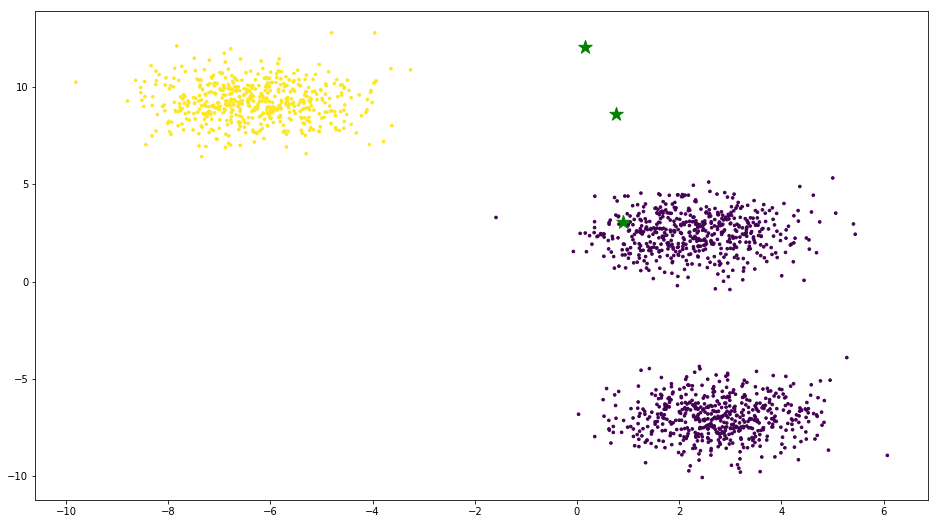

In [25]:
# Split the sequence in a number of chunks and process those independently.
n_workers = 4
n_iter =5

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c=[actdata.label for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [27]:
for iter in range(0, n_iter):    

    print(C.shape)
    
    
    #class assignnment
    lazy_partials_Estep = group(kmeans_tasks.s(task='estep', C=C, X=seq) for seq in Xsubseqs)() # call remote workers to run the sort task 
    partials_Estep = lazy_partials_Estep.get() # will wait for the tasks to return
    #partials_Estep=[kmeans_tasks(task='estep', C=C, X=seq) for seq in Xsubseqs]
    
    #centroid update assignnment
    lazy_partials_Mstep = group(kmeans_tasks.s(task='mstep', X=seq, n_clusters=n_clusters, n_features=n_features) for seq in partials_Estep)()
    partials_Mstep = lazy_partials_Mstep.get()
    #partials_Mstep=[kmeans_tasks(task='mstep', X=seq, n_clusters=n_clusters, n_features=n_features) for seq in partials_Estep]
    
    
    C=np.sum(partials_Mstep,0)/n_workers
    C_old = deepcopy(C)
    error = dist(C, C_old, None)
    print(error)

    Xsubseqs=deepcopy(partials_Estep)
    
    # for plotting the results
    mydata_updated=[]
    for seq in partials_Estep:
        mydata_updated.extend(seq)
        print(len(seq))
    len(mydata_updated)

    plt.rcParams['figure.figsize'] = (16, 9)
    fig = plt.figure()
    plt.scatter([actdata.points[0] for actdata in mydata_updated], [actdata.points[1] for actdata in mydata_updated],c=[actdata.label for actdata in mydata_updated], s=7)
    plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
    plt.show()
    
    #time.sleep(2)




(3, 2)


EncodeError: Object of type 'matrix' is not JSON serializable